In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


import seaborn as sns

import xgboost as xgb

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_log_error, mean_squared_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# -------------------------------
# 1. Load and process the old data (2015-2020)
# -------------------------------

There are no missing values in the old dataset


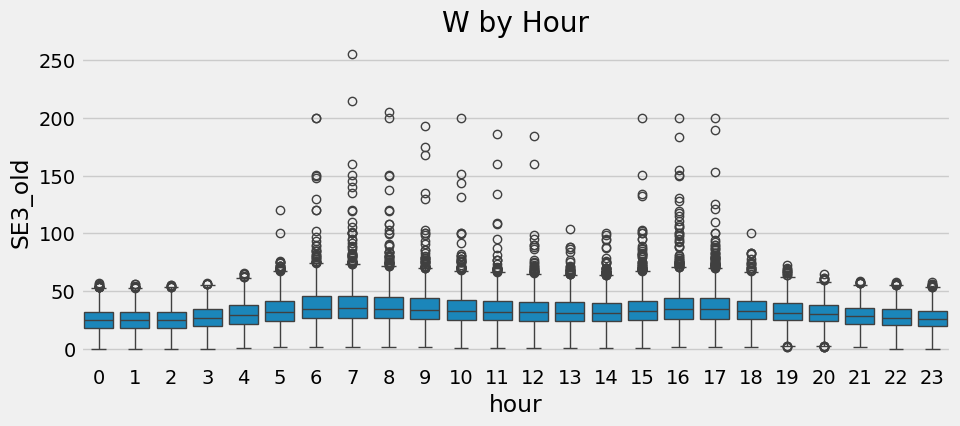

C:\Users\adamm\AppData\Local\Temp\ipykernel_19036\1125488875.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_old, x='month', y='SE3_old', palette='Blues')


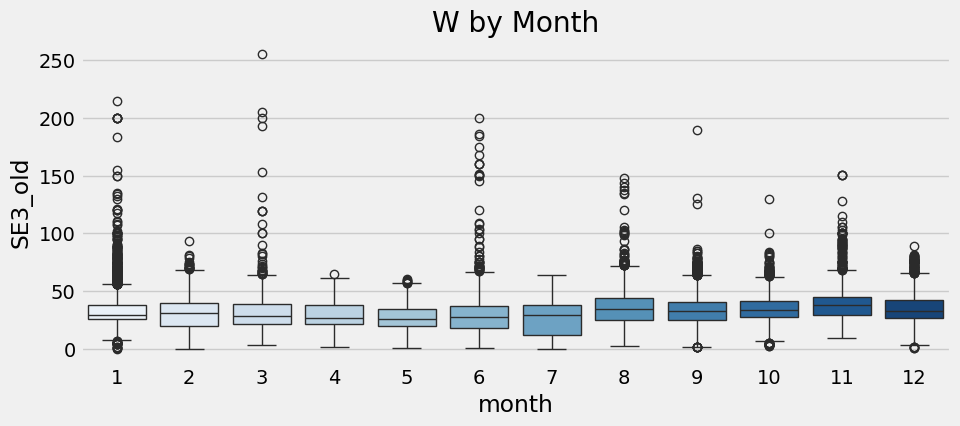

In [3]:

old_file_path = "C:/_Projects/home-energy-ai/data/raw/Elspotprices/sweden_elspot_prices.csv"
df_old = pd.read_csv(old_file_path, parse_dates=["cet_cest_timestamp"], index_col="cet_cest_timestamp")

# Keep only the SE3 column and fill missing values
df_old = df_old[["SE3"]].ffill().bfill()

if df_old.isnull().values.any() or df_old.isna().values.any():
    print("There are missing values in the old dataset")
else:
    print("There are no missing values in the old dataset")

# Convert index to datetime (first as UTC then remove timezone)
df_old.index = pd.to_datetime(df_old.index, utc=True)
df_old.index = df_old.index.tz_localize(None)

# Rename column for clarity
df_old.rename(columns={"SE3": "SE3_old"}, inplace=True)






### Feature Creation
def create_features(df, price_col):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    df['prev_hour'] = df[price_col].shift(1)  # Lagged consumption
    df['prev_day'] = df[price_col].shift(24)  # Consumption same time yesterday
    df['rolling_mean_6h'] = df[price_col].rolling(6).mean()
    df['rolling_std_6h'] = df[price_col].rolling(6).std()
    df['rolling_max_6h'] = df[price_col].rolling(6).max()

    return df

df_old = create_features(df_old, "SE3_old")

fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(data=df_old, x='hour', y='SE3_old')
ax.set_title('W by Hour')
plt.show()

fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(data=df_old, x='month', y='SE3_old', palette='Blues')
ax.set_title('W by Month')
plt.show()


# -------------------------------
# 2. Train a model on the old data
# -------------------------------

In [4]:
def train_model(train, test, TARGET, FEATURES):

    train = create_features(train, TARGET)
    test = create_features(test, TARGET)

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    # XGBoost model with hyperparameter tuning
    params = {
        'n_estimators': [100, 200],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.3],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }


    reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    cv = TimeSeriesSplit(n_splits=5)
    grid_search = GridSearchCV(reg, params, cv=cv, scoring='neg_mean_absolute_error', verbose=1)
    grid_search.fit(X_train, y_train)

    return grid_search.best_estimator_, X_test, X_train, y_test, y_train



In [5]:

train = df_old.loc[df_old.index < '01-01-2019']

test = df_old.loc[df_old.index >= '01-01-2019']


TARGET = 'SE3_old'
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']

# Best model
best_xgb, X_test, X_train, y_test, y_train = train_model(train, test, TARGET, FEATURES)


[0]	validation_0-rmse:11.04124	validation_1-rmse:16.97397
[99]	validation_0-rmse:3.85243	validation_1-rmse:22.28822
Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [ ]:

def use_model(best_xgb, X_test, y_test):
    y_pred = best_xgb.predict(X_test)

    # Evaluation Metrics
    
    print("minimum valuesin test: ",y_test.min(), y_pred.min())
    if y_test.min() < 0 or y_pred.min() < 0: 
        exit()
    else:
        mape = mean_absolute_percentage_error(y_test, y_pred)
        msle = mean_squared_log_error(y_test, y_pred)
        print(f"MAPE: {mape:.4f}")
        print(f"MSLE: {msle:.4f}")
        print(f"Peak Error: {peak_err:.4f}")
        
    def peak_error(y_true, y_pred):
        peak_indices = np.where(y_true > np.percentile(y_true, 90))[0]
        return np.mean(np.abs(y_true.iloc[peak_indices] - y_pred[peak_indices]))

    peak_err = peak_error(y_test, y_pred)



    # Plot predictions vs actual
    test['Predictions'] = y_pred
    test[[TARGET, 'Predictions']].plot(figsize=(15, 5), title='Actual vs. Predicted Power Consumption')
    plt.show()
    
    # fi = pd.DataFrame(data=reg.feature_importances_,
    #             index=reg.feature_names_in_,
    #             columns=['importance'])
    # fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
    # plt.show()



use_model(best_xgb, X_test, y_test)



# -------------------------------
# 3. Load and process the new data (2015-2024)
# -------------------------------

In [ ]:

new_file_path = r"C:\_Projects\home-energy-ai\data\raw\Elspotprices\Elspotprices 2015- 2024.csv"
df_new = pd.read_csv(new_file_path, sep=';', decimal=',')

df_new = df_new.ffill().bfill()

if df_new.isnull().values.any() or df_new.isna().values.any():
    print("There are missing values in the new dataset")
else:
    print("There are no missing values in the new dataset")


# Filter for SE3 rows
df_new = df_new[df_new['PriceArea'] == 'SE3'].copy()

# Parse the HourUTC column as datetime and set as index
df_new['HourUTC'] = pd.to_datetime(df_new['HourUTC'])
df_new.set_index('HourUTC', inplace=True)

# Convert SpotPriceEUR to öre/kWh.
# Here, we use an example exchange rate: 1 EUR = 10 SEK.
# Since 1 SEK = 100 öre, the conversion is: SpotPriceEUR * exchange_rate * 100.
exchange_rate = 10
df_new['SE3_new'] = (df_new['SpotPriceEUR'] * exchange_rate * 100)/1000

df_new

In [ ]:
train = df_new.loc[df_new.index < '01-01-2022']

test = df_new.loc[df_new.index >= '01-01-2022']


TARGET = 'SE3_new'
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']

# Best model
best_xgb, X_test, X_train, y_test, y_train = train_model(train, test, TARGET, FEATURES)

In [ ]:
use_model(best_xgb, X_test, y_test)

# -------------------------------
# 4. Compare data from a random common day
# -------------------------------

In [ ]:

# Find common days in both datasets (using normalized dates)
old_days = df_old.index.normalize().unique()
new_days = df_new.index.normalize().unique()
common_days = np.intersect1d(old_days, new_days)

if len(common_days) == 0:
    print("No common days found between the datasets.")
else:
    # Pick one random day from the overlapping dates
    random_day = pd.Timestamp(np.random.choice(common_days))
    print(f"Comparing data for {random_day.date()}")


    df_old = df_old.sort_index()
    df_new = df_new.sort_index()

    # Filter the dataframes for that day.
    # The string format 'YYYY-MM-DD' works for slicing by day.
    day_str = random_day.strftime('%Y-%m-%d')
    # day_str = '2020-01-01'
    df_old_day = df_old.loc[day_str]
    df_new_day = df_new.loc[day_str]


    # Plot the two series in subplots
    fig, axs = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

    axs[0].plot(df_old_day.index, df_old_day['SE3_old'], label='Old Data (SE3)', color='blue')
    axs[0].set_title(f"Old Data (2015-2020) on {random_day.date()}")
    axs[0].set_ylabel("Price (Öre/kWh)")
    axs[0].legend()

    axs[1].plot(df_new_day.index, df_new_day['SE3_new'], label='New Data (SE3)', color='orange')
    axs[1].set_title(f"New Data (2015-2024) on {random_day.date()} (in öre/kWh)")
    axs[1].set_ylabel("Price (öre/kWh)")
    axs[1].legend()

    plt.xlabel("Time")
    plt.tight_layout()
    plt.show()
